In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import colors

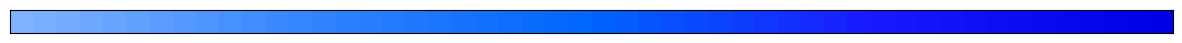

In [2]:
IMAGES_PATH = '.'
db_size = '10.0'
df_data = pd.read_csv(f'../data/classic_agent_history/agent_history_sf{db_size}_50epi.csv')
q_df_data = pd.read_csv(f'../data/hybrid_agent_history/quantum_agent_history_sf{db_size}_k0.00017_50epi.csv')
title_prefix = '10MB_database'
episodes = 50
steps_per_episode = 100
max_iterations = episodes * steps_per_episode
step = 50


def make_Ramp(ramp_colors):
    from colour import Color
    from matplotlib.colors import LinearSegmentedColormap

    color_ramp = LinearSegmentedColormap.from_list('my_list', [Color(c1).rgb for c1 in ramp_colors])
    plt.figure(figsize=(15, 3))
    plt.imshow([list(np.arange(0, len(ramp_colors), 0.1))], interpolation='nearest', origin='lower', cmap=color_ramp)
    plt.xticks([])
    plt.yticks([])
    return color_ramp


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# custom_cmap = make_Ramp(['#005ce6', '#069AF3', '#66ccff', '#ffbf80', '#ffa64d', '#ff7f0e', '#ffbb33'])
custom_cmap = make_Ramp(['#80b3ff', '#3385ff', '#0066ff', '#1a1aff', '#0000e6'])


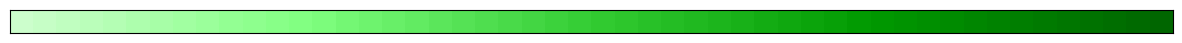

In [3]:
q_custom_cmap = make_Ramp(['#ccffcc', '#80ff80', '#33cc33', '#009900', '#006600'])

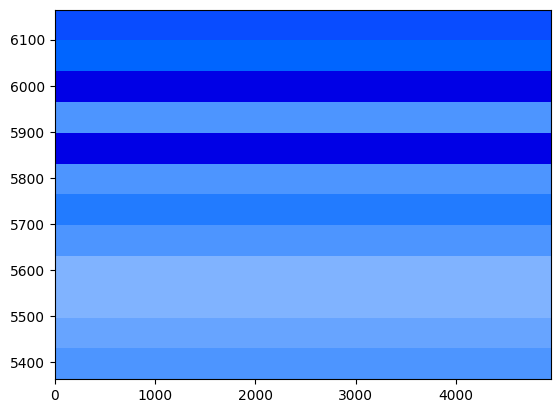

In [4]:
hist, x, y, _ = plt.hist2d(df_data[::step].index, df_data[::step]['initial_state_reward'], bins=(1, 12),
                           cmap=custom_cmap)
hist = [0.0, *hist[0], 0.0]
hist_intervals = pd.IntervalIndex.from_arrays(np.insert(y, 0, 0, axis=0),
                                              np.insert(y, y.size, np.inf, axis=0),
                                              closed='left')
df_data['hist'] = df_data['reward'].apply(
    lambda r: hist[hist_intervals.get_loc(r)] / (df_data.index.max() / step) * 100)



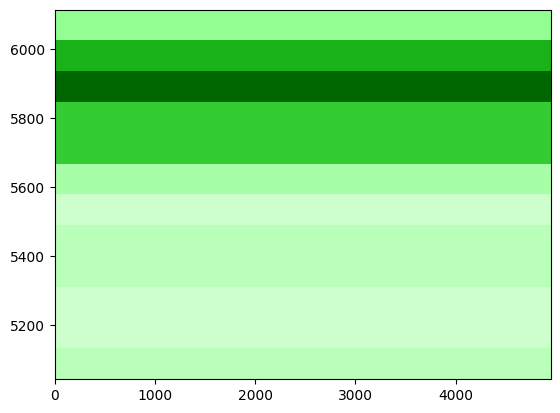

In [5]:
hist, x, y, _ = plt.hist2d(q_df_data[::step].index, q_df_data[::step]['initial_state_reward'], bins=(1, 12),
                           cmap=q_custom_cmap)
hist = [0.0, *hist[0], 0.0]
hist_intervals = pd.IntervalIndex.from_arrays(np.insert(y, 0, 0, axis=0),
                                              np.insert(y, y.size, np.inf, axis=0),
                                              closed='left')
q_df_data['hist'] = q_df_data['reward'].apply(
    lambda r: hist[hist_intervals.get_loc(r)] / (q_df_data.index.max() / step) * 100)

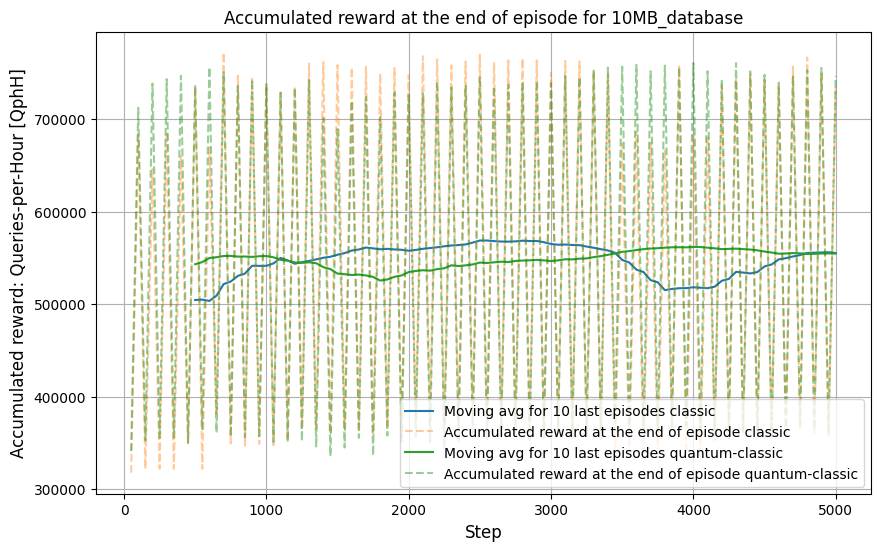

In [6]:
# total_reward
rolling_probe = step / 5
plt.figure(figsize=(10, 6))
plt.grid()
plt.ylabel('Accumulated reward: Queries-per-Hour [QphH]', fontsize=12)
plt.xlabel('Step', fontsize=12)
plt.title(f'Accumulated reward at the end of episode for {title_prefix}')

plt.plot(df_data['total_reward'][step - 1::step].rolling(window=int(rolling_probe)).mean(), '-',
         label=f'Moving avg for {int(rolling_probe)} last episodes classic')
plt.plot(df_data['total_reward'][step - 1::step], '--', alpha=0.4,
         label='Accumulated reward at the end of episode classic')

plt.plot(q_df_data['total_reward'][step - 1::step].rolling(window=int(rolling_probe)).mean(), '-',
         label=f'Moving avg for {int(rolling_probe)} last episodes quantum-classic')
plt.plot(q_df_data['total_reward'][step - 1::step], 'g--', alpha=0.4,
         label='Accumulated reward at the end of episode quantum-classic')

plt.legend(loc='lower right', fontsize=10)

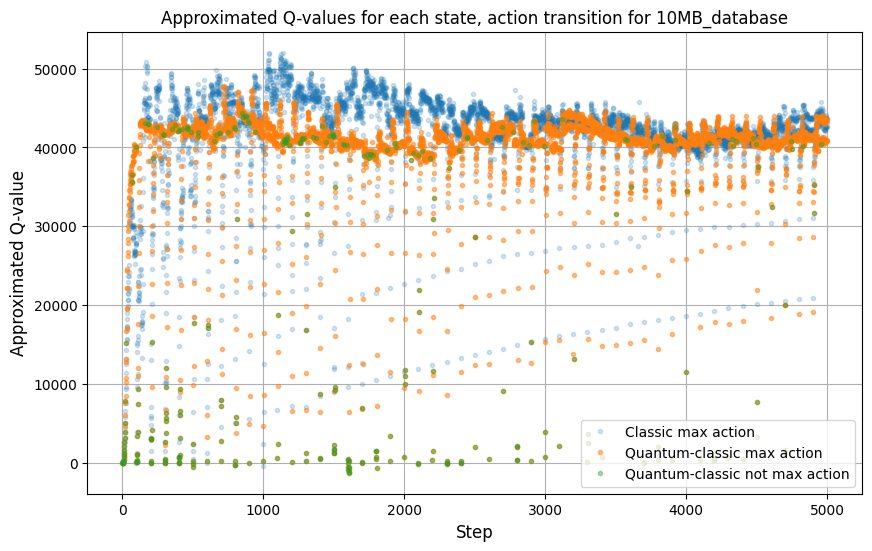

In [7]:
# aprox q
plt.figure(figsize=(10, 6))
plt.grid()
plt.ylabel('Approximated Q-value', fontsize=12)
plt.xlabel('Step', fontsize=12)
plt.title(f'Approximated Q-values for each state, action transition for {title_prefix}')
plt.plot(df_data['q'], '.', alpha=0.2, label='Classic max action')
plt.plot(q_df_data['q'], '.', alpha=0.5,label='Quantum-classic max action')
plt.plot(q_df_data[q_df_data['is_max_a'] == False]['q'], '.', alpha=0.4,label='Quantum-classic not max action')
plt.legend(loc='lower right', fontsize=10)

Text(0.5, 0, 'Step')

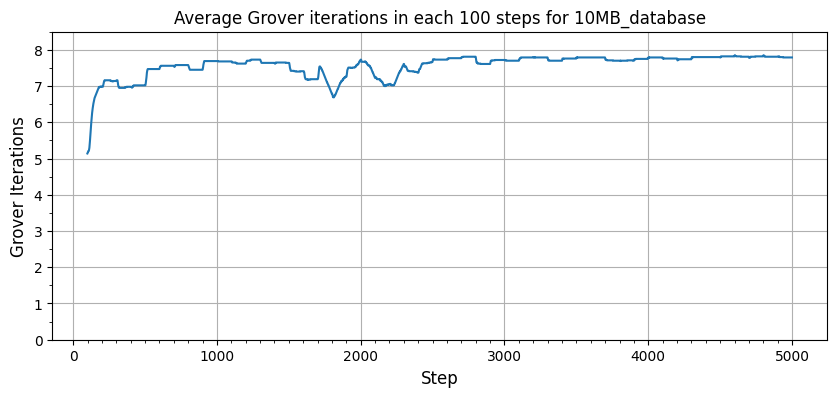

In [8]:
plt.figure(figsize=(10, 4))
plt.grid()

plt.plot(q_df_data['grover_iterations'].rolling(window=steps_per_episode).mean(), '-')
plt.title(f'Average Grover iterations in each {steps_per_episode} steps for {title_prefix}')

plt.yticks(np.arange(0, 9, step=0.5), minor=True)
plt.ylabel('Grover Iterations', fontsize=12)

plt.xticks(np.arange(steps_per_episode, max_iterations, step=steps_per_episode), minor=True)
plt.xlabel('Step', fontsize=12)

Text(0.5, 0, 'Step')

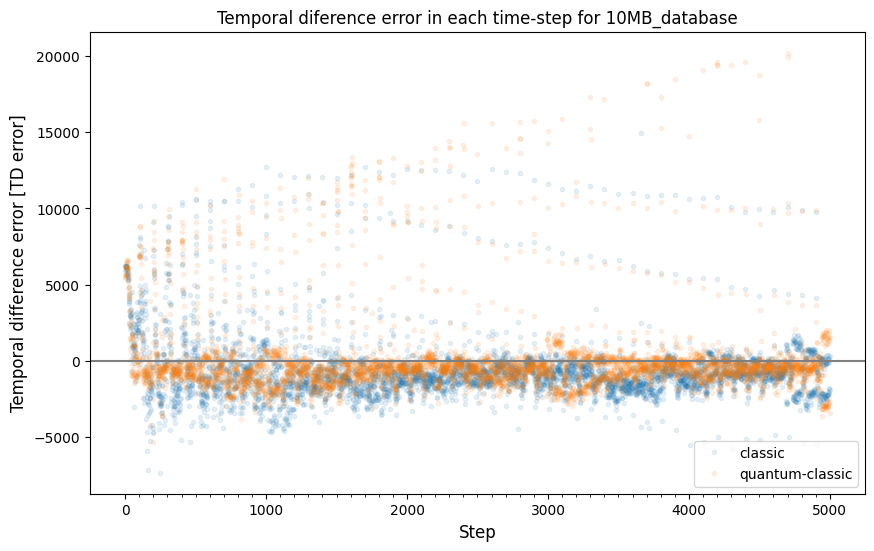

In [9]:

plt.figure(figsize=(10, 6))
plt.title(f'Temporal diference error in each time-step for {title_prefix}')
plt.plot(df_data['td_error'], '.', alpha=0.1, label='classic')
plt.plot(q_df_data['td_error'], '.', alpha=0.1, label='quantum-classic')
plt.axhline(y=0, color='grey')
plt.legend(loc='lower right', fontsize=10)

plt.ylabel('Temporal difference error [TD error]', fontsize=12)

plt.xticks(np.arange(0, max_iterations, step=steps_per_episode), minor=True)
plt.xlabel('Step', fontsize=12)


# Final Data

In [10]:
interval = 100
nr_slices = episodes

In [11]:
def get_data_interval(i: int) -> (int, int):
    return ((interval * i), (interval * (i + 1)))

In [12]:
# Classic
# 			
data = {
        "initial_state_reward": [], "reward_average": [],
        "min_reward": [], "max_reward": [],
        "max_total_reward": [], "td_error_average": [],
        "sum_power_queries_exec_time_sec": [], "average_power_queries_exec_time_sec": [], 
        "sum_power_refresh_function_exec_time_sec": [], "average_power_refresh_function_exec_time_sec": [], 
        "sum_throughput_total_exec_time_sec": [], "average_throughput_total_exec_time_sec": [], 
        "sum_step_execution_time_seconds": []
        }

for i in range(0, nr_slices):
    initial_interval, last_interval = get_data_interval(i)
    data_slice = df_data[initial_interval:last_interval]

    data["initial_state_reward"].append(data_slice["initial_state_reward"].max())
    data["reward_average"].append(data_slice["reward"].mean())
    data["min_reward"].append(data_slice["reward"].min())
    data["max_reward"].append(data_slice["reward"].max())
    data["max_total_reward"].append(data_slice["total_reward"].max())
    data["td_error_average"].append(data_slice["td_error"].mean())

    data["sum_power_queries_exec_time_sec"].append(data_slice["power_queries_exec_time_sum_sec"].sum())
    data["average_power_queries_exec_time_sec"].append(data_slice["power_queries_exec_time_sum_sec"].mean())
    data["sum_power_refresh_function_exec_time_sec"].append(data_slice["power_refresh_function_exec_time_sum_sec"].sum())
    data["average_power_refresh_function_exec_time_sec"].append(data_slice["power_refresh_function_exec_time_sum_sec"].mean())
    data["sum_throughput_total_exec_time_sec"].append(data_slice["throughput_total_exec_time_sec"].sum())
    data["average_throughput_total_exec_time_sec"].append(data_slice["throughput_total_exec_time_sec"].mean())
    data["sum_step_execution_time_seconds"].append(data_slice["step_execution_time_seconds"].sum())

pd.DataFrame(data, index=[i + 1 for i in range(0, nr_slices)]).style.format(precision=3, decimal=".")

,initial_state_reward,reward_average,min_reward,max_reward,max_total_reward,td_error_average,sum_power_queries_exec_time_sec,average_power_queries_exec_time_sec,sum_power_refresh_function_exec_time_sec,average_power_refresh_function_exec_time_sec,sum_throughput_total_exec_time_sec,average_throughput_total_exec_time_sec,sum_step_execution_time_seconds
1,5398.117,6836.443,5800.483,8007.229,683644.316,2958.152,20.426,0.204,2.589,0.026,23.248,0.232,81.317
2,5761.994,6462.581,5796.319,6934.395,646258.053,326.366,22.057,0.221,2.430,0.024,24.317,0.243,82.897
3,6063.509,6859.036,5691.362,7984.745,685903.554,83.168,20.704,0.207,2.437,0.024,23.038,0.230,80.895
4,5838.154,6597.048,5640.191,7203.164,659704.825,-359.864,21.106,0.211,2.484,0.025,23.538,0.235,81.689
5,6161.515,7355.082,5813.819,8233.858,735508.239,515.759,19.052,0.191,2.445,0.024,21.658,0.217,77.585
6,5970.991,6693.174,5711.514,8109.069,669317.428,-638.148,21.227,0.212,2.469,0.025,23.462,0.235,81.915
7,5975.766,7718.590,5812.981,8419.489,771858.999,-122.442,17.756,0.178,2.523,0.025,20.672,0.207,76.098
8,6140.822,7470.724,5500.674,8337.409,747072.446,-429.535,18.756,0.188,2.537,0.025,21.400,0.214,77.167
9,6164.985,7438.147,5851.210,8333.132,743814.742,-302.393,18.581,0.186,2.528,0.025,21.309,0.213,77.239
10,5770.778,7365.003,5730.290,8304.069,736500.329,-404.500,18.796,0.188,2.496,0.025,21.392,0.214,77.537


In [13]:
# Quantum-Classic

data = {
        "initial_state_reward": [], "reward_average": [],
        "min_reward": [], "max_reward": [],
        "max_total_reward": [], "td_error_average": [], "min_grover_iterations": [], "grover_iterations_average": [],
        "sum_power_queries_exec_time_sec": [], "average_power_queries_exec_time_sec": [], 
        "sum_power_refresh_function_exec_time_sec": [], "average_power_refresh_function_exec_time_sec": [], 
        "sum_throughput_total_exec_time_sec": [], "average_throughput_total_exec_time_sec": [], 
        "sum_step_execution_time_seconds": []
        }

for i in range(0, nr_slices):
    initial_interval, last_interval = get_data_interval(i)
    data_slice = q_df_data[initial_interval:last_interval]

    data["initial_state_reward"].append(data_slice["initial_state_reward"].max())
    data["reward_average"].append(data_slice["reward"].mean())
    data["min_reward"].append(data_slice["reward"].min())
    data["max_reward"].append(data_slice["reward"].max())
    data["max_total_reward"].append(data_slice["total_reward"].max())
    data["td_error_average"].append(data_slice["td_error"].mean())
    data["min_grover_iterations"].append(float(data_slice["grover_iterations"].min()))
    data["grover_iterations_average"].append(data_slice["grover_iterations"].mean())

    data["sum_power_queries_exec_time_sec"].append(data_slice["power_queries_exec_time_sum_sec"].sum())
    data["average_power_queries_exec_time_sec"].append(data_slice["power_queries_exec_time_sum_sec"].mean())
    data["sum_power_refresh_function_exec_time_sec"].append(data_slice["power_refresh_function_exec_time_sum_sec"].sum())
    data["average_power_refresh_function_exec_time_sec"].append(data_slice["power_refresh_function_exec_time_sum_sec"].mean())
    data["sum_throughput_total_exec_time_sec"].append(data_slice["throughput_total_exec_time_sec"].sum())
    data["average_throughput_total_exec_time_sec"].append(data_slice["throughput_total_exec_time_sec"].mean())
    data["sum_step_execution_time_seconds"].append(data_slice["step_execution_time_seconds"].sum())

pd.DataFrame(data, index=[i + 1 for i in range(0, nr_slices)]).style.format(precision=3, decimal=".")

,initial_state_reward,reward_average,min_reward,max_reward,max_total_reward,td_error_average,min_grover_iterations,grover_iterations_average,sum_power_queries_exec_time_sec,average_power_queries_exec_time_sec,sum_power_refresh_function_exec_time_sec,average_power_refresh_function_exec_time_sec,sum_throughput_total_exec_time_sec,average_throughput_total_exec_time_sec,sum_step_execution_time_seconds
1,5042.420,7122.336,5409.929,7900.578,712233.572,1996.757,0.000,5.140,19.587,0.196,2.463,0.025,22.511,0.225,93.377
2,6016.914,7383.919,5568.242,8212.918,738391.854,463.254,1.000,6.980,18.494,0.185,2.620,0.026,21.425,0.214,97.279
3,5817.870,7433.595,5635.551,8318.633,743359.532,399.286,1.000,7.150,18.406,0.184,2.523,0.025,21.484,0.215,97.793
4,5958.352,7469.501,5662.425,8183.167,746950.106,685.762,1.000,6.980,18.511,0.185,2.486,0.025,21.119,0.211,97.277
5,5872.855,7358.491,5531.584,8288.480,735849.137,620.515,1.000,7.020,18.656,0.187,2.495,0.025,21.580,0.216,97.759
6,5891.228,7561.245,5682.215,8401.726,756124.464,195.192,1.000,7.470,18.150,0.182,2.579,0.026,20.887,0.209,100.289
7,5892.033,7516.947,5510.091,8307.266,751694.712,79.068,1.000,7.560,18.181,0.182,2.581,0.026,21.146,0.211,99.218
8,6113.112,7358.769,5665.513,8085.522,735876.890,-295.627,1.000,7.580,18.670,0.187,2.455,0.025,21.157,0.212,97.832
9,5880.669,7431.008,5679.902,8186.873,743100.832,-176.540,1.000,7.450,18.655,0.187,2.413,0.024,21.146,0.211,98.584
10,5953.902,7378.523,5689.694,8102.159,737852.308,-462.136,1.000,7.690,18.534,0.185,2.430,0.024,21.268,0.213,98.580
